In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math as m
import os
from time import time as tm
from numba import cuda, njit, vectorize
from time import sleep, time
from findhubs import *
from a_star import *
from astro import *
from ConCreate import *

In [2]:
ConstParam = pd.read_excel(os.path.join('inputs', 'Constellation.xlsx'))
CP = ConstellationParameters(ConstParam['Satellites'].to_numpy(),ConstParam['Planes'].to_numpy(),
                             np.radians(ConstParam['Inclination'].to_numpy()),ConstParam['Altitude'].to_numpy(),
                             ConstParam['Raan shift'].to_numpy(),ConstParam['Shift'].to_numpy())


Constellation = CreateConstellation(CP)
Params = IniConstellation(CP,Constellation,[])
cartSat = UpdateConstellation(Params,Constellation,0)

In [15]:
T = 1000
lens = []
for t in range(T):
    result = pd.read_csv(f'C:\\Users\Harkn\Desktop\BroadbandConst\outputs\PathsN\Paths_{t}.csv')
#     lens.append(result['Length [m]'].to_numpy())
    lens.append(result['Length [nodes]'].to_numpy())

lens = np.asarray(lens)

In [16]:
lens.mean(),lens.max(), np.median(lens),lens[lens!=0].min()

(6.0871382575757575, 46, 4.0, 1)

In [3]:
Trafs = []
T = 1000
for sat in Constellation:
    sat.links.forward.data = 0
    sat.links.backward.data = 0
    sat.links.left.data = 0
    sat.links.right.data = 0
for t in range(T):
    result = pd.read_csv(f'C:\\Users\Harkn\Desktop\BroadbandConst\outputs\PathsL\Paths_{t}.csv')
    Paths = [[int(n) for n in path[1:-1].split()] for path in result['Path'].values]
    for path in Paths:   
        for n in range(len(path)-1):
            master = path[n]
            slave = path[n+1]
            data = result.loc[master,'Traffic']

            if slave == Constellation[master].links.forward.to.globalid:
                Constellation[master].links.forward.data += data
            elif slave == Constellation[master].links.backward.to.globalid:
                Constellation[master].links.backward.data += data
            elif slave == Constellation[master].links.left.to.globalid:
                Constellation[master].links.left.data += data      
            elif slave == Constellation[master].links.right.to.globalid:
                Constellation[master].links.right.data += data  
    trafs = []
    for sat in Constellation:
        trafs.append([sat.links.forward.data,sat.links.backward.data,sat.links.left.data,sat.links.right.data])
    Trafs.append(trafs)
    
    for sat in Constellation:
        sat.links.forward.data = 0
        sat.links.backward.data = 0
        sat.links.left.data = 0
        sat.links.right.data = 0
    
Trafs = np.asarray(Trafs)*0.1*8

In [4]:
Trafs.shape

(1000, 1584, 4)

In [226]:
Full = []
for t in range(T):
    cartSat = UpdateConstellation(Params,Constellation,t)
    Distances = []
    for sat in Constellation:
        indexes = [link.globalid for link in sat.links.list]
        satC = cartSat[sat.globalid]
        linkC = cartSat[indexes]
        dists = np.sqrt(((linkC - satC)**2).sum(1))
        Distances.append(dists)
    Full.append(Distances)
BR = Trafs*1e9
Full = np.asarray(Full)

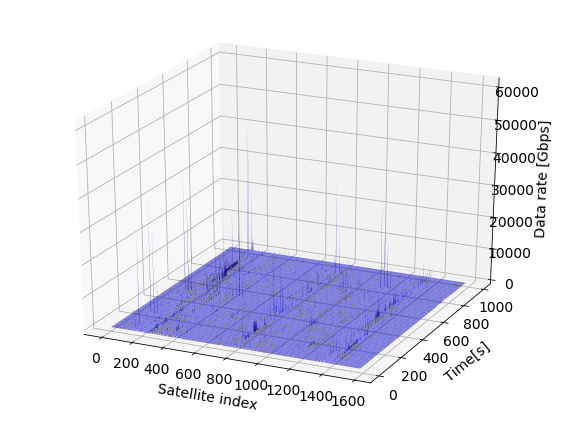

In [164]:
from mpl_toolkits.mplot3d import Axes3D
fontsize = 14

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
from matplotlib import cm

X = np.arange(Trafs.shape[1])
Y = np.arange(T)
X, Y = np.meshgrid(X, Y)
Fr = Trafs.T[0,:,:].T
Br = Trafs.T[1,:,:].T
Lf = Trafs.T[2,:,:].T
Rg = Trafs.T[3,:,:].T

# Plot the surface.
# ax.plot_wireframe(X, Y, Fr,alpha=0.4,color = 'purple')
# ax.plot_wireframe(X, Y, Br,alpha=0.4,color = 'red')
# ax.plot_wireframe(X, Y, Lf,alpha=0.4,color = 'green')
# ax.plot_wireframe(X, Y, Rg,alpha=0.4,color = 'blue')

# ax.plot_surface(X, Y, Fr,alpha=0.5,color = 'purple')
# ax.plot_surface(X, Y, Br,alpha=0.5,color = 'orange')
# ax.plot_surface(X, Y, Lf,alpha=0.5,color = 'green')
ax.plot_surface(X, Y, Rg,alpha=0.5,color = 'blue')




plt.xlabel('Satellite index',fontsize = fontsize)
plt.ylabel('Time[s]',fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
ax.zaxis.set_tick_params(labelsize = fontsize)
ax.yaxis.labelpad = 10
ax.xaxis.labelpad = 10
ax.zaxis.labelpad = 10
ax.set_zlabel('Data rate [Gbps]',fontsize = fontsize)
ax.view_init(25,-65)
plt.tight_layout()

# plt.savefig('Figures/DataRateConstL.png',dpi=100)
# plt.savefig('Figures/DataRateConstTRG.png',dpi=100)
# plt.savefig('Figures/DataRateConstN.png',dpi=100)

In [210]:
np.median(Trafs[Trafs!=0]), Trafs[Trafs!=0].mean(),Trafs[Trafs!=0].max()

(16.418227648449648, 272.5856662967058, 70483.75513140004)

In [216]:
a = [1,1,1,10]
np.median(a),np.mean(a)

(1.0, 3.25)

In [227]:
h = 6.62607015e-34
c = 299792458
wavelength = 1064e-9
E = h*c/wavelength
thetta = 5e-6/2
# thetta = 0

NoF = 133
nt = nr = 0.6
Dt = Dr = 0.135
Gr = (np.pi*Dt/wavelength)**2
Gt = (np.pi*Dr/wavelength)**2
Lt = np.e**(-Gt*thetta**2)
Lr = np.e**(-Gr*thetta**2)
M = 10**(5/10)
# BR = 1e9
# R = 2e6
R = Full
Ls = (wavelength/(4*np.pi*R))**2
Pt = E*NoF*BR*M/(nt*nr*Gt*Gr*Lt*Lr*Ls)
# print(Pt)

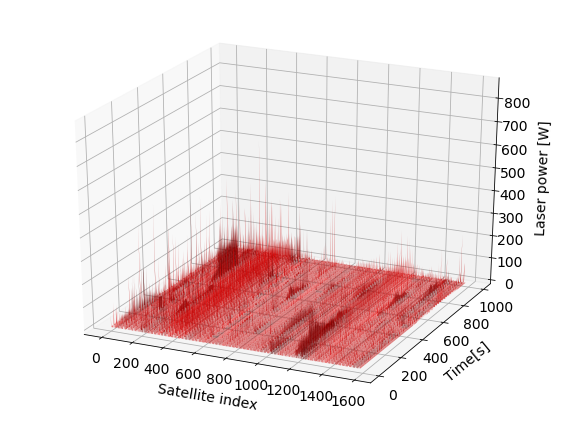

In [228]:
from mpl_toolkits.mplot3d import Axes3D
fontsize = 14

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
from matplotlib import cm

X = np.arange(Pt.sum(0).shape[0])
Y = np.arange(T)
X, Y = np.meshgrid(X, Y)
Z = Pt.sum(2)

# Plot the surface.
ax.plot_surface(X, Y, Z,alpha=0.5,color = 'red')
# ax.plot_wireframe(X, Y, Rg,alpha=0.4,color = 'red')
plt.xlabel('Satellite index',fontsize = fontsize)
plt.ylabel('Time[s]',fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
ax.zaxis.set_tick_params(labelsize = fontsize)
ax.set_zlabel('Laser power [W]',fontsize = fontsize)
ax.yaxis.labelpad = 10
ax.xaxis.labelpad = 10
ax.zaxis.labelpad = 10


ax.view_init(25,-65)
plt.tight_layout()

plt.savefig('Figures/LaserPowerConstL.png',dpi=100)
# plt.savefig('Figures/LaserPowerConstT.png',dpi=100)
# plt.savefig('Figures/LaserPowerConstN.png',dpi=100)



In [176]:
(Trafs[:,:,0][Trafs[:,:,0]!=0]).mean()

270.61823671101155

In [229]:
np.median(Trafs[Trafs!=0]), Pt[Pt!=0].mean(),Pt.max()

(99.76682604254495, 6.017522139369771, 857.4968946170715)

NameError: name 'GS' is not defined